# CoNLL_4.ipynb

This notebook contains the fourth part of the model training and analysis code from our CoNLL-2020 paper, ["Identifying Incorrect Labels in the CoNLL-2003 Corpus"](https://www.aclweb.org/anthology/2020.conll-1.16/).

If you're new to the Text Extensions for Pandas library, we recommend that you start
by reading through the notebook [`Analyze_Model_Outputs.ipynb`](https://github.com/CODAIT/text-extensions-for-pandas/blob/master/notebooks/Analyze_Model_Outputs.ipynb), which explains the 
portions of the library that we use in the notebooks in this directory.

### Summary

This notebook repeats the model training process from `CoNLL_3.ipynb`, but performs a 10-fold cross-validation. This process involves training a total of 170 models -- 10 groups of 17. Next, this notebook evaluates each group of models over the holdout set from the associated fold of the cross-validation. Then it aggregates together these outputs and uses the same techniques used in `CoNLL_2.ipynb` to flag potentially-incorrect labels. Finally, the notebook writes out CSV files containing ranked lists of potentially-incorrect labels.



# Libraries and constants

In [1]:
# Libraries
import numpy as np
import pandas as pd
import os
import sys
import time
import torch
import transformers
from typing import *
import sklearn.model_selection
import sklearn.pipeline
import matplotlib.pyplot as plt
import multiprocessing
import gc

# And of course we need the text_extensions_for_pandas library itself.
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    raise Exception("text_extensions_for_pandas package not found on the Jupyter "
                    "kernel's path. Please either run:\n"
                    "   ln -s ../../text_extensions_for_pandas .\n"
                    "from the directory containing this notebook, or use a Python "
                    "environment on which you have used `pip` to install the package.")

from text_extensions_for_pandas import cleaning

# Use hardware acceleration if present.
if torch.backends.mps.is_available():
    torch.set_default_device("mps")
elif torch.backends.cuda.is_available():
    torch.set_default_device("cuda")
    
# BERT Configuration
# Keep this in sync with `CoNLL_3.ipynb`.
#bert_model_name = "bert-base-uncased"
#bert_model_name = "bert-large-uncased"
bert_model_name = "dslim/bert-base-NER"
tokenizer = transformers.BertTokenizerFast.from_pretrained(bert_model_name)
bert = transformers.BertModel.from_pretrained(bert_model_name)

# If False, use cached values, provided those values are present on disk
_REGENERATE_EMBEDDINGS = True
_REGENERATE_MODELS = True

# Number of dimensions that we reduce the BERT embeddings down to when
# training reduced-quality models.
#_REDUCED_DIMS = [8, 16, 32, 64, 128, 256]
_REDUCED_DIMS = [32, 64, 128, 256]

# How many models we train at each level of dimensionality reduction
_MODELS_AT_DIM = [4] * len(_REDUCED_DIMS)

# Consistent set of random seeds to use when generating dimension-reduced
# models. Index is [index into _REDUCED_DIMS, model number], and there are
# lots of extra entries so we don't need to resize this matrix.
from numpy.random import default_rng
_MASTER_SEED = 42
rng = default_rng(_MASTER_SEED)
_MODEL_RANDOM_SEEDS = rng.integers(0, 1e6, size=(8, 8))

# Create a Pandas categorical type for consistent encoding of categories
# across all documents.
_ENTITY_TYPES = ["LOC", "MISC", "ORG", "PER"]
token_class_dtype, int_to_label, label_to_int = tp.io.conll.make_iob_tag_categories(_ENTITY_TYPES)

# Parameters for splitting the corpus into folds
_KFOLD_RANDOM_SEED = _MASTER_SEED
_KFOLD_NUM_FOLDS = 10


# Read inputs

Read in the corpus, retokenize it with the BERT tokenizer, add BERT embeddings, and convert
to a single dataframe.

In [2]:
# Download and cache the data set.
# NOTE: This data set is licensed for research use only. Be sure to adhere
#  to the terms of the license when using this data set!
data_set_info = tp.io.conll.maybe_download_conll_data("outputs")
data_set_info

{'train': 'outputs/eng.train',
 'dev': 'outputs/eng.testa',
 'test': 'outputs/eng.testb'}

In [3]:
# The raw dataset in its original tokenization
corpus_raw = {}
for fold_name, file_name in data_set_info.items():
    df_list = tp.io.conll.conll_2003_to_dataframes(file_name, 
                                          ["pos", "phrase", "ent"],
                                          [False, True, True])
    corpus_raw[fold_name] = [
        df.drop(columns=["pos", "phrase_iob", "phrase_type"])
        for df in df_list
    ]

In [4]:
# Retokenize with the BERT tokenizer and regenerate embeddings.
corpus_df,token_class_dtype, int_to_label, label_to_int = cleaning.preprocess.preprocess_documents(corpus_raw,'ent_type',True,carry_cols=['line_num'],iob_col='ent_iob')

preprocessing fold train


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=946, style=ProgressStyle(desc…

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


preprocessing fold dev


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=216, style=ProgressStyle(desc…

preprocessing fold test


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=231, style=ProgressStyle(desc…

# Prepare folds for a 10-fold cross-validation

We divide the documents of the corpus into 10 random samples.

In [5]:
# IDs for each of the keys
doc_keys = corpus_df[["fold", "doc_num"]].drop_duplicates().reset_index(drop=True)
doc_keys

,fold,doc_num
0,train,0
1,train,1
2,train,2
3,train,3
4,train,4
...,...,...
1388,test,226
1389,test,227
1390,test,228
1391,test,229


In [6]:
# We want to split the documents randomly into _NUM_FOLDS sets, then
# for each stage of cross-validation train a model on the union of
# (_NUM_FOLDS - 1) of them while testing on the remaining fold.
# sklearn.model_selection doesn't implement this approach directly,
# but we can piece it together with some help from Numpy.
#from numpy.random import default_rng
rng = np.random.default_rng(seed=_KFOLD_RANDOM_SEED)
iloc_order = rng.permutation(len(doc_keys.index))
kf = sklearn.model_selection.KFold(n_splits=_KFOLD_NUM_FOLDS)

train_keys = []
test_keys = []
for train_ix, test_ix in kf.split(iloc_order):
    # sklearn.model_selection.KFold gives us a partitioning of the
    # numbers from 0 to len(iloc_order). Use that partitioning to 
    # choose elements from iloc_order, then use those elements to 
    # index into doc_keys.
    train_iloc = iloc_order[train_ix]
    test_iloc = iloc_order[test_ix]
    train_keys.append(doc_keys.iloc[train_iloc])
    test_keys.append(doc_keys.iloc[test_iloc])

train_keys[1].head(10)

,fold,doc_num
146,train,146
1164,test,2
483,train,483
1190,test,28
20,train,20
237,train,237
86,train,86
408,train,408
1252,test,90
1213,test,51


# Dry run: Train and evaluate models on the first fold

Train models on the first of our 10 folds and manually examine some of the 
model outputs.

In [7]:
# Gather the training set together by joining our list of documents
# with the entire corpus on the composite key <fold, doc_num>
train_inputs_df = corpus_df.merge(train_keys[0])
train_inputs_df

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,raw_span,line_num,raw_span_id,ent_iob,ent_type,embedding,token_class,token_class_id
0,train,0,0,"[0, 0): ''",101,0,1,True,NaN,NaN,NaN,O,<NA>,"[ -0.09850524, -0.4050192, 0.742887...",O,0
1,train,0,1,"[0, 1): '-'",118,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.057022177, -0.48112157, 0.9898...",O,0
2,train,0,2,"[1, 2): 'D'",141,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.048242822, -0.25329977, 1.167193...",O,0
3,train,0,3,"[2, 4): 'OC'",9244,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.266829, -0.3100878, 1.007474...",O,0
4,train,0,4,"[4, 6): 'ST'",9272,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.22297007, -0.21308552, 0.933102...",O,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371472,test,230,314,"[1386, 1393): 'brother'",1711,0,1,False,"[1386, 1393): 'brother'",50345.0,267.0,O,<NA>,"[ -0.02817185, -0.0806234, 0.9804883...",O,0
371473,test,230,315,"[1393, 1394): ','",117,0,1,False,"[1393, 1394): ','",50346.0,268.0,O,<NA>,"[ 0.118174165, -0.070084296, 0.8654851...",O,0
371474,test,230,316,"[1395, 1400): 'Bobby'",5545,0,1,False,"[1395, 1400): 'Bobby'",50347.0,269.0,B,PER,"[ -0.35689434, 0.31400457, 1.573852...",B-PER,3
371475,test,230,317,"[1400, 1401): '.'",119,0,1,False,"[1400, 1401): '.'",50348.0,270.0,O,<NA>,"[ -0.18957077, -0.2458121, 0.662573...",O,0


In [8]:
# Repeat the same process for the test set
test_inputs_df = corpus_df.merge(test_keys[0])
test_inputs_df

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,raw_span,line_num,raw_span_id,ent_iob,ent_type,embedding,token_class,token_class_id
0,train,12,0,"[0, 0): ''",101,0,1,True,NaN,NaN,NaN,O,<NA>,"[ -0.101977654, -0.4244247, 0.84401846, ...",O,0
1,train,12,1,"[0, 1): '-'",118,0,1,False,"[0, 10): '-DOCSTART-'",2664.0,0.0,O,<NA>,"[ -0.09124554, -0.47710684, 1.1202921, ...",O,0
2,train,12,2,"[1, 2): 'D'",141,0,1,False,"[0, 10): '-DOCSTART-'",2664.0,0.0,O,<NA>,"[ -0.16952737, -0.27063495, 1.2095658, ...",O,0
3,train,12,3,"[2, 4): 'OC'",9244,0,1,False,"[0, 10): '-DOCSTART-'",2664.0,0.0,O,<NA>,"[ -0.27648136, -0.3675849, 1.0920238, ...",O,0
4,train,12,4,"[4, 6): 'ST'",9272,0,1,False,"[0, 10): '-DOCSTART-'",2664.0,0.0,O,<NA>,"[ -0.24050584, -0.24247584, 1.0751178, ...",O,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45059,test,225,75,"[208, 213): 'fight'",2147,0,1,False,"[208, 213): 'fight'",49418.0,29.0,O,<NA>,"[ -0.0962138, -0.48016918, 0.510937, ...",O,0
45060,test,225,76,"[214, 216): 'on'",1113,0,1,False,"[214, 216): 'on'",49419.0,30.0,O,<NA>,"[ -0.085863255, -0.23417273, 0.8329261, ...",O,0
45061,test,225,77,"[217, 225): 'Saturday'",4306,0,1,False,"[217, 225): 'Saturday'",49420.0,31.0,O,<NA>,"[ -0.012237908, -0.4282665, 0.61948353, ...",O,0
45062,test,225,78,"[225, 226): '.'",119,0,1,False,"[225, 226): '.'",49421.0,32.0,O,<NA>,"[ -0.042956144, -0.36315376, 0.6602027, ...",O,0


## Train an ensemble of models

In [9]:
import importlib
import sklearn.linear_model
import ray
ray.init()

# Wrap train_reduced_model in a Ray task
@ray.remote
def train_reduced_model_task(
        x_values: np.ndarray, y_values: np.ndarray, n_components: int,
        seed: int, max_iter: int = 10000) -> sklearn.base.BaseEstimator:
    return cleaning.ensemble.train_reduced_model(x_values, y_values, n_components, seed, max_iter)

# Ray task that trains a model using the entire embedding
@ray.remote
def train_full_model_task(x_values: np.ndarray, y_values: np.ndarray, 
                          max_iter: int = 10000) -> sklearn.base.BaseEstimator:
    return (
        sklearn.linear_model.LogisticRegression(
            #multi_class="multinomial", 
            max_iter=max_iter
        )
        .fit(x_values, y_values)
    )

def train_models(train_df: pd.DataFrame) \
        -> Dict[str, sklearn.base.BaseEstimator]:
    """
    Train an ensemble of models with different levels of noise.
    
    :param train_df: DataFrame of labeled training documents, with one
     row per token. Must contain the columns "embedding" (precomputed 
     BERT embeddings) and "token_class_id" (integer ID of token type)
     
    :returns: A mapping from mnemonic model name to trained model
    """
    X = train_df["embedding"].values
    Y = train_df["token_class_id"]
    

    # Push the X and Y values to Plasma so that our tasks can share them.
    X_id = ray.put(X.to_numpy().copy())
    Y_id = ray.put(Y.to_numpy().copy())
    
    names_list = []
    futures_list = []
    
    print(f"Training model using all of "
          f"{X._tensor.shape[1]}-dimension embeddings.")
    names_list.append(f"{X._tensor.shape[1]}_1")
    futures_list.append(train_full_model_task.remote(X_id, Y_id))   
    
    for i in range(len(_REDUCED_DIMS)):
        num_dims = _REDUCED_DIMS[i]
        num_models = _MODELS_AT_DIM[i]
        for j in range(num_models):
            model_name = f"{num_dims}_{j + 1}"
            seed = _MODEL_RANDOM_SEEDS[i, j]
            print(f"Training model '{model_name}' (#{j + 1} "
                  f"at {num_dims} dimensions) with seed {seed}")
            names_list.append(model_name)
            futures_list.append(train_reduced_model_task.remote(X_id, Y_id, 
                                                                num_dims, seed))
    
    # Block until all training tasks have completed and fetch the resulting models.
    models_list = ray.get(futures_list)
    models = {
        n: m for n, m in zip(names_list, models_list)
    }
    return models

def maybe_train_models(train_df: pd.DataFrame, fold_num: int):
    import pickle
    _CACHED_MODELS_FILE = f"outputs/fold_{fold_num}_models.pickle"
    if _REGENERATE_MODELS or not os.path.exists(_CACHED_MODELS_FILE):
        m = train_models(train_df)
        print(f"Trained {len(m)} models.")
        with open(_CACHED_MODELS_FILE, "wb") as f:
            pickle.dump(m, f)
    else:
        # Use a cached model when using cached embeddings
        with open(_CACHED_MODELS_FILE, "rb") as f:
            m = pickle.load(f)
            print(f"Loaded {len(m)} models from {_CACHED_MODELS_FILE}.")
    return m

models = maybe_train_models(train_inputs_df, 0)
print(f"Model names after loading or training: {', '.join(models.keys())}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training model using all of 768-dimension embeddings.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model '256_3' (#3 at 256 dimensions) with seed 402414
Training model '256

In [10]:
# Uncomment this code if you need to have the cells that follow ignore
# some of the models saved to disk.
# _MODEL_SIZES_TO_KEEP = [32, 64, 128, 256]
# _RUNS_TO_KEEP = [4] * len(_MODEL_SIZES_TO_KEEP)
# _OTHER_MODELS_TO_KEEP = ["768_1"]

# to_keep = _OTHER_MODELS_TO_KEEP.copy()
# for size in _MODEL_SIZES_TO_KEEP:
#     for num_runs in _RUNS_TO_KEEP:
#         for i in range(num_runs):
#             to_keep.append(f"{size}_{i+1}")

# models = {k: v for k, v in models.items() if k in to_keep}

# print(f"Model names after filtering: {', '.join(models.keys())}")

## Evaluate the models on this fold's test set

In [11]:
def eval_models(models: Dict[str, sklearn.base.BaseEstimator],
                test_df: pd.DataFrame):
    """
    Bulk-evaluate an ensemble of models generated by :func:`train_models`.
    
    :param models: Output of :func:`train_models`
    :param test_df:  DataFrame of labeled test documents, with one
     row per token. Must contain the columns "embedding" (precomputed 
     BERT embeddings) and "token_class_id" (integer ID of token type)
    
    :returns: A dictionary from model name to results of 
     :func:`util.analyze_model`
    """
    todo = [(name, model) for name, model in models.items()]
    results = tp.jupyter.run_with_progress_bar(
        len(todo),
        lambda i: cleaning.infer_and_extract_entities_iob(test_df,corpus_raw, int_to_label, todo[i][1]),
        "model"
    )
    return {t[0]: result for t, result in zip(todo, results)}

evals = eval_models(models, test_inputs_df)
# display one of the results
evals[list(evals.keys())[0]].head()

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

,span,ent_type,fold,doc_num
0,"[11, 16): 'Saudi'",MISC,train,12
1,"[59, 65): 'MANAMA'",LOC,train,12
2,"[86, 91): 'Saudi'",MISC,train,12
3,"[259, 264): 'Saudi'",MISC,train,12
0,"[55, 65): 'MONTGOMERY'",LOC,train,20


In [12]:
# Summarize how each of the models does on the test set.
gold_elts = cleaning.preprocess.combine_raw_spans_docs_to_match(corpus_raw,evals[list(evals.keys())[0]],label_col = 'ent_type')
def make_summary_df(evals_df: pd.DataFrame) -> pd.DataFrame:
    gold_elts = cleaning.preprocess.combine_raw_spans_docs_to_match(corpus_raw, evals['256_4'], label_col = 'ent_type')
    summary_df= cleaning.analysis.create_f1_report_ensemble_iob(evals,gold_elts)
    summary_df['dims'] = [int(name.split('_')[0]) for name in evals.keys()]
    return summary_df

summary_df = make_summary_df(evals)
summary_df

,precision,recall,f1-score,dims
768_1,0.952096,0.943742,0.947900,768
32_1,0.924096,0.864000,0.893038,32
32_2,0.925089,0.876387,0.900080,32
32_3,0.924966,0.865290,0.894133,32
32_4,0.932967,0.876387,0.903792,32
64_1,0.938490,0.901677,0.919716,64
64_2,0.940290,0.902194,0.920848,64
64_3,0.937112,0.896000,0.916095,64
64_4,0.942442,0.904258,0.922955,64
128_1,0.945191,0.925677,0.935332,128


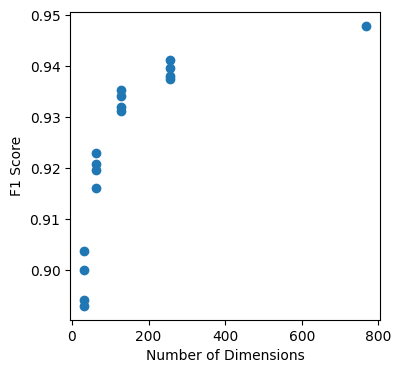

In [13]:
# Plot the tradeoff between dimensionality and F1 score
x = summary_df["dims"]
y = summary_df["f1-score"]

plt.figure(figsize=(4,4))
plt.scatter(x, y)
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Number of Dimensions")
plt.ylabel("F1 Score")

# Also dump the raw data to a local file.
pd.DataFrame({"num_dims": x, "f1_score": y}).to_csv("outputs/dims_vs_f1_score_xval.csv",
                                                    index=False)

plt.show()

## Aggregate the model results and compare with the gold standard

In [14]:
full_results = cleaning.flag_suspicious_labels(evals,'ent_type','ent_type',label_name='ent_type',gold_feats=gold_elts,align_over_cols=['fold','doc_num','span'],keep_cols=[],split_doc=False)
full_results

,fold,doc_num,span,ent_type,in_gold,count,models
4918,train,907,"[590, 598): 'Gorleben'",LOC,True,17,"[GOLD, 768_1, 32_1, 32_2, 32_3, 32_4, 64_1, 64..."
4916,train,907,"[63, 67): 'BONN'",LOC,True,17,"[GOLD, 768_1, 32_1, 32_2, 32_3, 32_4, 64_1, 64..."
4915,train,907,"[11, 17): 'German'",MISC,True,17,"[GOLD, 768_1, 32_1, 32_2, 32_3, 32_4, 64_1, 64..."
4914,train,896,"[523, 528): 'China'",LOC,True,17,"[GOLD, 768_1, 32_1, 32_2, 32_3, 32_4, 64_1, 64..."
4913,train,896,"[512, 518): 'Mexico'",LOC,True,17,"[GOLD, 768_1, 32_1, 32_2, 32_3, 32_4, 64_1, 64..."
...,...,...,...,...,...,...,...
242,dev,120,"[63, 70): 'English'",MISC,True,0,[GOLD]
115,dev,81,"[70, 76): 'AL-RAM'",LOC,True,0,[GOLD]
113,dev,81,"[58, 69): 'Sami Aboudi'",PER,True,0,[GOLD]
2,dev,21,"[86, 90): 'UEFA'",ORG,True,0,[GOLD]


In [15]:
# Drop Boolean columns for now
results = full_results[["fold", "doc_num", "span", "ent_type", "in_gold", "count"]]
results

,fold,doc_num,span,ent_type,in_gold,count
4918,train,907,"[590, 598): 'Gorleben'",LOC,True,17
4916,train,907,"[63, 67): 'BONN'",LOC,True,17
4915,train,907,"[11, 17): 'German'",MISC,True,17
4914,train,896,"[523, 528): 'China'",LOC,True,17
4913,train,896,"[512, 518): 'Mexico'",LOC,True,17
...,...,...,...,...,...,...
242,dev,120,"[63, 70): 'English'",MISC,True,0
115,dev,81,"[70, 76): 'AL-RAM'",LOC,True,0
113,dev,81,"[58, 69): 'Sami Aboudi'",PER,True,0
2,dev,21,"[86, 90): 'UEFA'",ORG,True,0


In [16]:
(results[results["in_gold"] == True][["count", "span"]]
 .groupby("count").count()
 .rename(columns={"span": "num_ents"}))

,num_ents
count,
0,116
1,26
2,23
3,25
4,14
5,21
6,27
7,12
8,21


In [17]:
(results[results["in_gold"] == False][["count", "span"]]
 .groupby("count").count()
 .rename(columns={"span": "num_ents"}))

,num_ents
count,
1,460
2,181
3,95
4,60
5,46
6,31
7,26
8,24
9,10


In [18]:
# Pull out some hard-to-find examples, sorting by document to make labeling easier
hard_to_get = results[results["in_gold"]].sort_values(["count", "fold", "doc_num"]).head(20)
hard_to_get

,fold,doc_num,span,ent_type,in_gold,count
2,dev,21,"[86, 90): 'UEFA'",ORG,True,0
0,dev,21,"[25, 39): 'STANDARD LIEGE'",ORG,True,0
115,dev,81,"[70, 76): 'AL-RAM'",LOC,True,0
113,dev,81,"[58, 69): 'Sami Aboudi'",PER,True,0
242,dev,120,"[63, 70): 'English'",MISC,True,0
370,dev,149,"[81, 93): 'Major League'",MISC,True,0
495,dev,182,"[2173, 2177): 'Ruch'",ORG,True,0
459,dev,182,"[662, 670): 'division'",MISC,True,0
510,dev,203,"[879, 881): '90'",LOC,True,0
619,dev,214,"[1689, 1705): 'Schindler's List'",MISC,True,0


### TODO: Relabel the above 20 examples with a Markdown table (copy from CSV)


In [19]:
# Hardest results not in the gold standard for models to avoid
hard_to_avoid = results[~results["in_gold"]].sort_values(["count", "fold", "doc_num"], ascending=[False, True, True]).head(20)
hard_to_avoid

,fold,doc_num,span,ent_type,in_gold,count
114,dev,81,"[58, 76): 'Sami Aboudi AL-RAM'",PER,False,17
369,dev,149,"[81, 102): 'Major League Baseball'",MISC,False,17
568,dev,214,"[187, 202): 'Michael Collins'",PER,False,17
980,test,23,"[94, 116): 'National Hockey League'",MISC,False,17
1108,test,25,"[856, 864): 'NFC East'",MISC,False,17
1107,test,25,"[823, 835): 'Philadelphia'",ORG,False,17
1182,test,41,"[674, 688): 'Sporting Gijon'",ORG,False,17
1324,test,114,"[51, 61): 'sales-USDA'",ORG,False,17
1367,test,118,"[776, 791): 'mid-Mississippi'",LOC,False,17
1362,test,118,"[535, 550): 'mid-Mississippi'",LOC,False,17


### TODO: Relabel the above 20 examples (copy from CSV)


# Remainder of Experiment

For each of the 10 folds, train a model on the fold's training set and run
analysis on the fold's test set.

In [20]:
def handle_fold(fold_ix: int) -> Dict[str, Any]:
    """
    The per-fold processing of the previous section's cells, collapsed into 
    a single function.
    
    :param fold_ix: 0-based index of fold
    
    :returns: a dictionary that maps data structure name to data structure
    """
    # To avoid accidentally picking up leftover data from a previous cell,
    # variables local to this function are named with a leading underscore
    _train_inputs_df = corpus_df.merge(train_keys[fold_ix])
    _test_inputs_df = corpus_df.merge(test_keys[fold_ix])
    _models = maybe_train_models(_train_inputs_df, fold_ix)
    _evals = eval_models(_models, _test_inputs_df)
    _summary_df = make_summary_df(_evals)
    _gold_elts = cleaning.preprocess.combine_raw_spans_docs_to_match(corpus_raw,_evals[list(evals.keys())[0]])
    _full_results = cleaning.flag_suspicious_labels(_evals,'ent_type','ent_type',
                                                    label_name='ent_type',
                                                    gold_feats=_gold_elts,
                                                    align_over_cols=['fold','doc_num','span'],
                                                    keep_cols=[],split_doc=False)
    _results = _full_results[["fold", "doc_num", "span", 
                              "ent_type", "in_gold", "count"]]
    return {
        "models": _models,
        "summary_df": _summary_df,
        "full_results": _full_results,
        "results": _results
    }

# Start with the (already computed) results for fold 0
results_by_fold = [
    {
        "models": models,
        "summary_df": summary_df,
        "full_results": full_results,
        "results": results
    }
]

for fold in range(1, _KFOLD_NUM_FOLDS):
    print(f"Starting fold {fold}.")
    results_by_fold.append(handle_fold(fold))
    print(f"Done with fold {fold}.")
    

Starting fold 1.
Training model using all of 768-dimension embeddings.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model '256_3' (#3 at 256 dimensions) with seed 402414
Tr

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

Done with fold 1.
Starting fold 2.
Training model using all of 768-dimension embeddings.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model '256_3' (#3 at 256 dimensions) w

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

Done with fold 2.
Starting fold 3.
Training model using all of 768-dimension embeddings.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model '256_3' (#3 at 256 dimensions) w

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

Done with fold 3.
Starting fold 4.
Training model using all of 768-dimension embeddings.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model '256_3' (#3 at 256 dimensions) w

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

Done with fold 4.
Starting fold 5.
Training model using all of 768-dimension embeddings.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model '256_3' (#3 at 256 dimensions) w

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

Done with fold 5.
Starting fold 6.
Training model using all of 768-dimension embeddings.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model '256_3' (#3 at 256 dimensions) w

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

Done with fold 6.
Starting fold 7.
Training model using all of 768-dimension embeddings.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model '256_3' (#3 at 256 dimensions) w

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

Done with fold 7.
Starting fold 8.
Training model using all of 768-dimension embeddings.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model '256_3' (#3 at 256 dimensions) w

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

Done with fold 8.
Starting fold 9.
Training model using all of 768-dimension embeddings.
Training model '32_1' (#1 at 32 dimensions) with seed 89250
Training model '32_2' (#2 at 32 dimensions) with seed 773956
Training model '32_3' (#3 at 32 dimensions) with seed 654571
Training model '32_4' (#4 at 32 dimensions) with seed 438878
Training model '64_1' (#1 at 64 dimensions) with seed 201469
Training model '64_2' (#2 at 64 dimensions) with seed 94177
Training model '64_3' (#3 at 64 dimensions) with seed 526478
Training model '64_4' (#4 at 64 dimensions) with seed 975622
Training model '128_1' (#1 at 128 dimensions) with seed 513226
Training model '128_2' (#2 at 128 dimensions) with seed 128113
Training model '128_3' (#3 at 128 dimensions) with seed 839748
Training model '128_4' (#4 at 128 dimensions) with seed 450385
Training model '256_1' (#1 at 256 dimensions) with seed 781567
Training model '256_2' (#2 at 256 dimensions) with seed 643865
Training model '256_3' (#3 at 256 dimensions) w

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=17, style=ProgressStyle(descr…

Done with fold 9.


In [21]:
# Combine all the results into a single dataframe for the entire corpus
all_results = pd.concat([r["results"] for r in results_by_fold])
all_results

,fold,doc_num,span,ent_type,in_gold,count
4918,train,907,"[590, 598): 'Gorleben'",LOC,True,17
4916,train,907,"[63, 67): 'BONN'",LOC,True,17
4915,train,907,"[11, 17): 'German'",MISC,True,17
4914,train,896,"[523, 528): 'China'",LOC,True,17
4913,train,896,"[512, 518): 'Mexico'",LOC,True,17
...,...,...,...,...,...,...
270,dev,93,"[469, 481): 'JAKARTA POST'",ORG,True,0
182,dev,76,"[1285, 1312): 'Chicago Purchasing Managers'",ORG,True,0
123,dev,49,"[1920, 1925): 'Tajik'",MISC,True,0
26,dev,15,"[109, 133): 'National Football League'",ORG,True,0


# Generate CSV files for manual labeling

In [22]:
# Reformat for output
dev_and_test_results = all_results[all_results["fold"].isin(["dev", "test"])]
in_gold_to_write, not_in_gold_to_write = cleaning.analysis.csv_prep(dev_and_test_results, "count")
in_gold_to_write

,count,fold,doc_offset,corpus_span,corpus_ent_type,error_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
1,0,dev,0,"[20, 34): 'LEICESTERSHIRE'",ORG,,,,,,,
30,0,dev,2,"[760, 765): 'Leeds'",ORG,,,,,,,
21,0,dev,2,"[614, 634): 'Duke of Norfolk's XI'",ORG,,,,,,,
7,0,dev,2,"[189, 218): 'Test and County Cricket Board'",ORG,,,,,,,
3,0,dev,2,"[87, 92): 'Ashes'",MISC,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
1742,17,test,230,"[230, 238): 'Charlton'",PER,,,,,,,
1741,17,test,230,"[177, 187): 'Englishman'",MISC,,,,,,,
1740,17,test,230,"[135, 142): 'Ireland'",LOC,,,,,,,
1739,17,test,230,"[87, 100): 'Jack Charlton'",PER,,,,,,,


In [23]:
not_in_gold_to_write

,count,fold,doc_offset,model_span,model_ent_type,error_type,corpus_span,corpus_ent_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
29,17,dev,2,"[760, 765): 'Leeds'",LOC,,,,,,,,,
20,17,dev,6,"[399, 404): 'Rotor'",PER,,,,,,,,,
16,17,dev,6,"[262, 267): 'Rotor'",PER,,,,,,,,,
143,17,dev,11,"[1961, 1975): 'Czech Republic'",LOC,,,,,,,,,
33,17,dev,13,"[83, 104): 'Major League Baseball'",MISC,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694,1,test,228,"[269, 287): 'Brazilian defender'",MISC,,,,,,,,,
1683,1,test,228,"[40, 43): 'SIX'",ORG,,,,,,,,,
1729,1,test,230,"[19, 29): 'ENGLISHMAN'",LOC,,,,,,,,,
1731,1,test,230,"[19, 29): 'ENGLISHMAN'",PER,,,,,,,,,


In [24]:
in_gold_to_write.to_csv("outputs/CoNLL_4_in_gold.csv", index=False)
not_in_gold_to_write.to_csv("outputs/CoNLL_4_not_in_gold.csv", index=False)

In [25]:
# Repeat for the contents of the original training set
train_results = all_results[all_results["fold"] == "train"]
in_gold_to_write, not_in_gold_to_write = cleaning.analysis.csv_prep(train_results, "count")
in_gold_to_write

,count,fold,doc_offset,corpus_span,corpus_ent_type,error_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
1482,0,train,6,"[121, 137): 'Toronto Dominion'",PER,,,,,,,
1344,0,train,24,"[384, 388): 'FLNC'",ORG,,,,,,,
1341,0,train,24,"[161, 169): 'Africans'",MISC,,,,,,,
1967,0,train,25,"[141, 151): 'mid-Norway'",MISC,,,,,,,
1368,0,train,28,"[1133, 1135): 'EU'",ORG,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
4111,17,train,945,"[130, 137): 'Preston'",ORG,,,,,,,
4110,17,train,945,"[119, 127): 'Plymouth'",ORG,,,,,,,
4109,17,train,945,"[72, 79): 'English'",MISC,,,,,,,
4108,17,train,945,"[43, 49): 'LONDON'",LOC,,,,,,,


In [26]:
not_in_gold_to_write

,count,fold,doc_offset,model_span,model_ent_type,error_type,corpus_span,corpus_ent_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
1729,17,train,3,"[0, 10): '-DOCSTART-'",LOC,,,,,,,,,
1481,17,train,6,"[121, 137): 'Toronto Dominion'",LOC,,,,,,,,,
1966,17,train,25,"[141, 151): 'mid-Norway'",LOC,,,,,,,,,
2024,17,train,29,"[762, 774): 'Mark O'Meara'",PER,,,,,,,,,
2000,17,train,29,"[454, 468): 'Phil Mickelson'",PER,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4415,1,train,943,"[25, 46): 'SAN MARINO GRAND PRIX'",PER,,,,,,,,,
4416,1,train,943,"[25, 28): 'SAN'",LOC,,,,,,,,,
4420,1,train,943,"[25, 41): 'SAN MARINO GRAND'",LOC,,,,,,,,,
4461,1,train,944,"[17, 32): 'BRITISH MASTERS'",LOC,,,,,,,,,


In [27]:
in_gold_to_write.to_csv("outputs/CoNLL_4_train_in_gold.csv", index=False)
not_in_gold_to_write.to_csv("outputs/CoNLL_4_train_not_in_gold.csv", index=False)